# Определение Венерианских вулканов при помощи сверточных нейронных сетей (CNN - convolutional neural networks)

Датасет составлен из фотографий вулканов Венеры, полученных миссиями NASA Magellan, запущенными 4 Мая 1989 и 10 Августа 1990. (https://www2.jpl.nasa.gov/magellan/)

## 1 Проверка датасета

In [1]:
# Подключение библиотек
import numpy as np 
import pandas as pd 
import os
from matplotlib import pyplot as plt

In [2]:
# Разбиение датасета на тренировочную и тестовую выборки
X_train = pd.read_csv('../input/volcanoes_train/train_images.csv')
y_train = pd.read_csv('../input/volcanoes_train/train_labels.csv')
X_test = pd.read_csv('../input/volcanoes_test/test_images.csv')
y_test = pd.read_csv('../input/volcanoes_test/test_labels.csv')

In [3]:
X_train.head()

95  101   99  103  95.1   86   96   89   70  104  ...  111.214  107.329  \
0   91   92   91   89    92   93   96  101  107  104  ...      103       92   
1   87   70   72   74    84   78   93  104  106  106  ...       84       71   
2    0    0    0    0     0    0    0    0    0    0  ...       94       81   
3  114  118  124  119    95  118  105  116  123  112  ...      116      113   
4   79   95   90   82    73   74   77   75   82   87  ...       90       80   

   92.354  89.258  103.379  99.414  117.112  116.103  118.82  96.423  
0      93      95       98     105      104      100      90      81  
1      95     102       94      80       91       80      84      90  
2      89      84       80      90       92       80      88      96  
3     102      93      109     104      106      117     111     115  
4      79      78       65      71       62       97      89      73  

[5 rows x 12100 columns]

In [4]:
y_train.head()

Volcano?  Type  Radius  Number Volcanoes
0         1   3.0   17.46               1.0
1         0   NaN     NaN               NaN
2         0   NaN     NaN               NaN
3         0   NaN     NaN               NaN
4         0   NaN     NaN               NaN

<ol>
  <p>В первой колонке информация - есть вулкан или нет (1 или 0)</p>
  <p>Во второй графе определенность вулкана на изображении (1 - точно есть, 2 - высоковероятно есть, 3 - возможно есть, 4 - видно только жерло).</p>
  <p>В третьей графе радиус вулкана в центре изображения, в пикселях.</p>
  <p>В четвертой графе число вулканов на изображении.</p>
</ol>

## 2 Подготовка датасета

In [5]:
# Размеры выборок
print("X_train ->",X_train.shape,"\ny_train ->",y_train.shape,"\nX_test ->",X_test.shape,"\ny_test ->",y_test.shape)

X_train -> (6999, 12100) 
y_train -> (7000, 4) 
X_test -> (2733, 12100) 
y_test -> (2734, 4)


In [6]:
def fixing_X(X): # Починка X (изображений)
    X.loc[-1] = X.columns.values.astype(float).astype(int)  # добавление имен колонок как новых столбцов
    X.index = X.index + 1  # смещение индексов
    X.sort_index(inplace=True)  # сортировка индексов

In [7]:
fixing_X(X_train)
fixing_X(X_test)

In [8]:
print("Новые размеры:\nX_train ->",X_train.shape,"\ny_train ->",y_train.shape,"\nX_test ->",X_test.shape,"\ny_test ->",y_test.shape)

Новые размеры:
X_train -> (7000, 12100) 
y_train -> (7000, 4) 
X_test -> (2734, 12100) 
y_test -> (2734, 4)


### 2.1 Проверка статистик

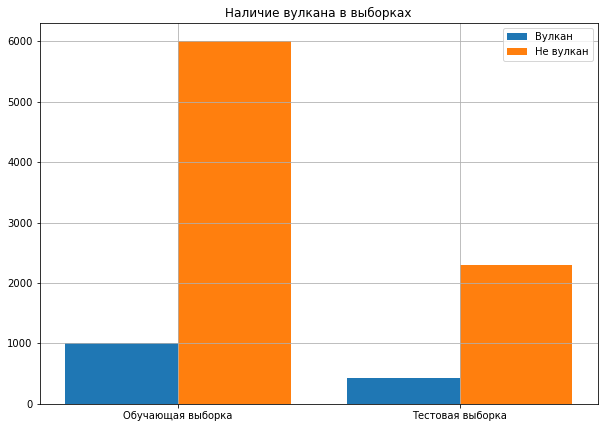

In [9]:
y_trainVolcanoCount = y_train[y_train["Volcano?"] == 1].shape[0]
y_testVolcanoCount = y_test[y_test["Volcano?"] == 1].shape[0]

y_trainNotVolcanoCount = y_train[y_train["Volcano?"] == 0].shape[0]
y_testNotVolcanoCount = y_test[y_test["Volcano?"] == 0].shape[0]

col = ['Обучающая выборка','Тестовая выборка']
true = [y_trainVolcanoCount, y_testVolcanoCount]
false = [y_trainNotVolcanoCount, y_testNotVolcanoCount]

x_axis = np.arange(len(col))

plt.rcParams["figure.figsize"] = (10,7)
plt.bar(x_axis -0.2, true, width=0.4, label = 'Вулкан')
plt.bar(x_axis +0.2, false, width=0.4, label = 'Не вулкан')

plt.xticks(x_axis, col)
plt.grid()
plt.legend()
plt.title('Наличие вулкана в выборках')
plt.show()


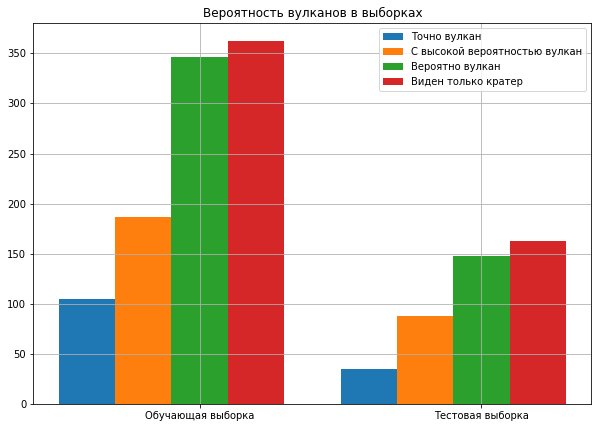

In [10]:
y_trainTypeDefinitelyCount = y_train[y_train["Type"] == 1].shape[0]
y_testTypeDefinitelyCount = y_test[y_test["Type"] == 1].shape[0]

y_trainTypeProbablyCount = y_train[y_train["Type"] == 2].shape[0]
y_testTypeProbablyCount = y_test[y_test["Type"] == 2].shape[0]

y_trainTypePossiblyCount = y_train[y_train["Type"] == 3].shape[0]
y_testTypePossiblyCount = y_test[y_test["Type"] == 3].shape[0]

y_trainTypePitCount = y_train[y_train["Type"] == 4].shape[0]
y_testTypePitCount = y_test[y_test["Type"] == 4].shape[0]

col = ['Обучающая выборка','Тестовая выборка']
y1 = [y_trainTypeDefinitelyCount, y_testTypeDefinitelyCount]
y2 = [y_trainTypeProbablyCount, y_testTypeProbablyCount]
y3 = [y_trainTypePossiblyCount, y_testTypePossiblyCount]
y4 = [y_trainTypePitCount, y_testTypePitCount]

plt.rcParams["figure.figsize"] = (10,7)
plt.bar(x_axis-0.4, y1, width=0.2, label = 'Точно вулкан')
plt.bar(x_axis -0.2, y2, width=0.2, label = 'С высокой вероятностью вулкан')
plt.bar(x_axis, y3, width=0.2, label = 'Вероятно вулкан')
plt.bar(x_axis +0.2, y4, width=0.2, label = 'Виден только кратер')


plt.title('Вероятность вулканов в выборках')
plt.xticks(x_axis, col)
plt.grid()
plt.legend()
plt.show()

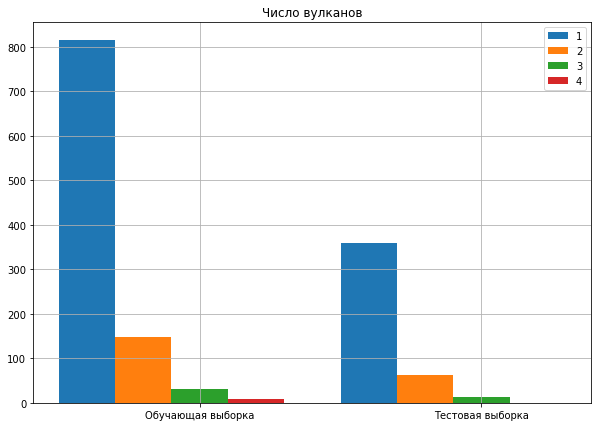

In [11]:
y_trainNumberVolcanoesOnelyCount = y_train[y_train["Number Volcanoes"] == 1].shape[0]
y_testNumberVolcanoesOneCount = y_test[y_test["Number Volcanoes"] == 1].shape[0]

y_trainNumberVolcanoesTwoCount = y_train[y_train["Number Volcanoes"] == 2].shape[0]
y_testNumberVolcanoesTwoCount = y_test[y_test["Number Volcanoes"] == 2].shape[0]

y_trainNumberVolcanoesThreeCount = y_train[y_train["Number Volcanoes"] == 3].shape[0]
y_testNumberVolcanoesThreeCount = y_test[y_test["Number Volcanoes"] == 3].shape[0]

y_trainNumberVolcanoesFourCount = y_train[y_train["Number Volcanoes"] >= 4].shape[0]
y_testNumberVolcanoesFourCount = y_test[y_test["Number Volcanoes"] >= 4].shape[0]

col = ['Обучающая выборка','Тестовая выборка']
y1 = [y_trainNumberVolcanoesOnelyCount, y_testNumberVolcanoesOneCount]
y2 = [y_trainNumberVolcanoesTwoCount, y_testNumberVolcanoesTwoCount]
y3 = [y_trainNumberVolcanoesThreeCount, y_testNumberVolcanoesThreeCount]
y4 = [y_trainNumberVolcanoesFourCount, y_testNumberVolcanoesFourCount]

plt.rcParams["figure.figsize"] = (10,7)
plt.bar(x_axis-0.4, y1, width=0.2, label = '1')
plt.bar(x_axis -0.2, y2, width=0.2, label = '2')
plt.bar(x_axis, y3, width=0.2, label = '3')
plt.bar(x_axis +0.2, y4, width=0.2, label = '4')


plt.title('Число вулканов')
plt.xticks(x_axis, col)
plt.grid()
plt.legend()
plt.show()

#### Можно заметить, что на большинстве изображений лишь один вулкан.
15% изображений содержат вулканы.
Только 10% - точно вулканы.

### 2.2 Вывод изображений

In [12]:
y_train_copy = y_train.copy(deep=True)
X_train_copy = X_train.copy(deep=True)
X_train_copy.shape
X_train_copy = np.resize(X_train_copy, (7000, 110, 110))

y_train_copy.loc[y_train_copy["Type"] == 1, 'Type'] = "Definitely Volcano"
y_train_copy.loc[y_train_copy["Type"] == 2, 'Type'] = "Probably Volcano"
y_train_copy.loc[y_train_copy["Type"] == 3, 'Type'] = "Possibly Volcano"
y_train_copy.loc[y_train_copy["Type"] == 4, 'Type'] = "Only Pit is Visible"

y_train_copy.loc[y_train_copy["Volcano?"] == 0, 'Volcano?'] = "Not Volcano"
y_train_copy.loc[y_train_copy["Volcano?"] == 1, 'Volcano?'] = "Volcano"

y_train_copy.loc[y_train_copy["Number Volcanoes"] == 1, 'Number Volcanoes'] = "One Volcano"
y_train_copy.loc[y_train_copy["Number Volcanoes"] == 2, 'Number Volcanoes'] = "Two Volcano"
y_train_copy.loc[y_train_copy["Number Volcanoes"] == 3, 'Number Volcanoes'] = "Three or More Volcano"
y_train_copy.loc[y_train_copy["Number Volcanoes"] == 4, 'Number Volcanoes'] = "Three or More Volcano"
y_train_copy.loc[y_train_copy["Number Volcanoes"] == 5, 'Number Volcanoes'] = "Three or More Volcano"

def draw_images(feature):
    featureTypes = (y_train_copy.groupby([feature])[feature].nunique()).index
    f, ax = plt.subplots(len(featureTypes)*2, 5, figsize=(12,6*len(featureTypes)))
    for i in range(len(featureTypes)*2):
        typ = featureTypes[int(i/2)]
        sample = y_train_copy[y_train_copy[feature]==typ].sample(5)
        for j in range(5):
            imageIndex = sample.iloc[j].name
            image = X_train_copy[imageIndex]
            ax[i, j].imshow(image, resample=True)
            ax[i, j].set_title(typ, fontsize=13)
    plt.tight_layout()
    plt.show()

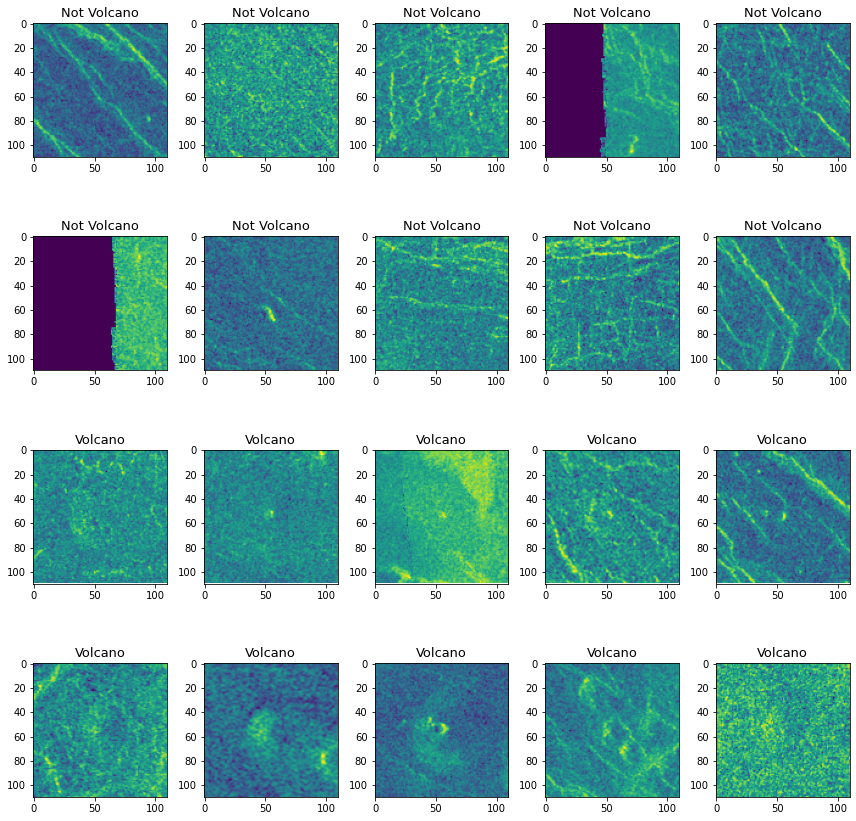

In [13]:
draw_images("Volcano?")

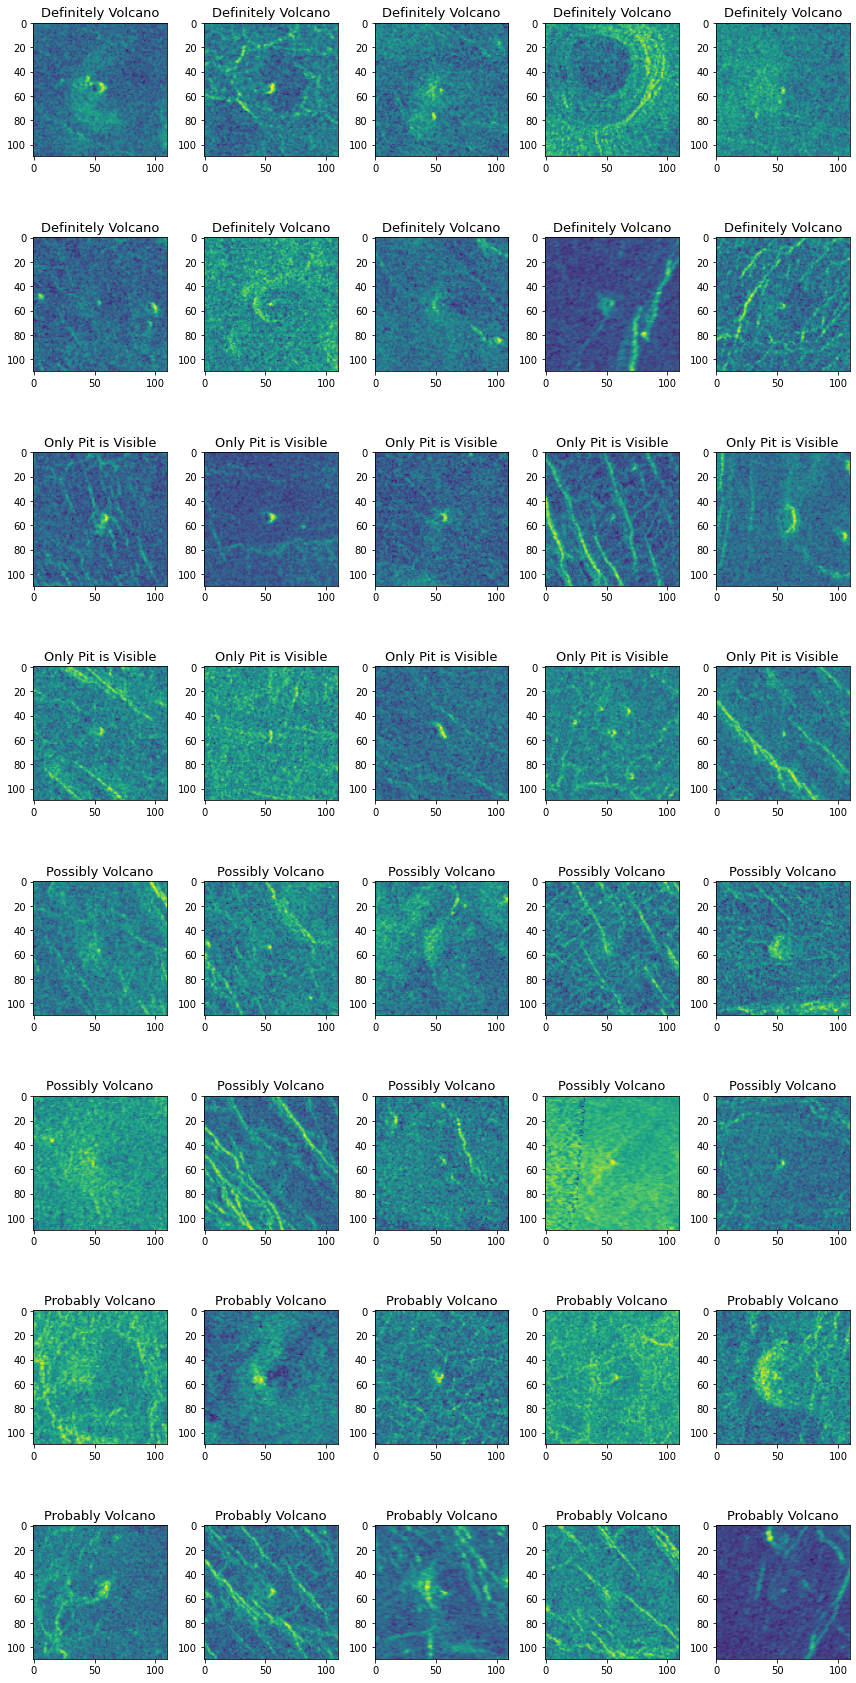

In [14]:
draw_images("Type")

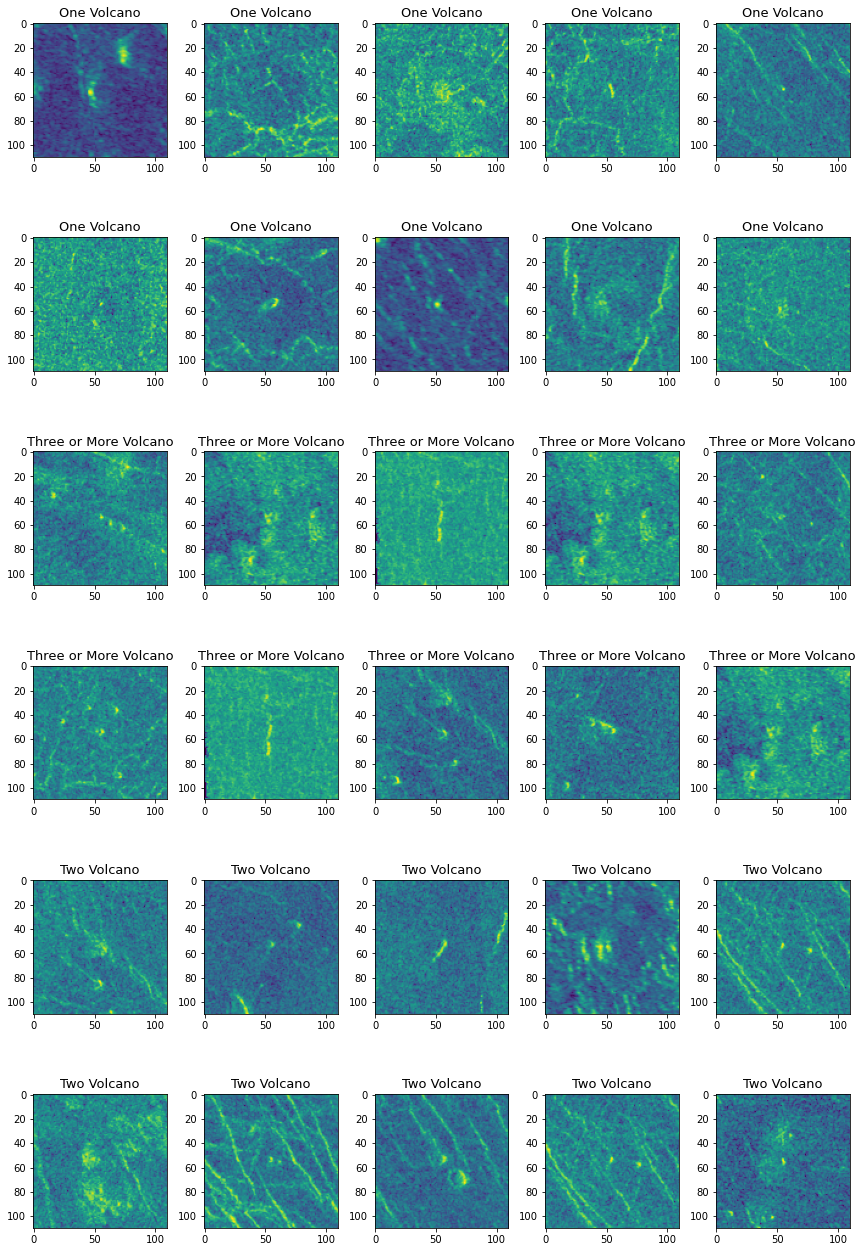

In [15]:
draw_images("Number Volcanoes")

### 2.3 Удаление испорченных изображений
Можно заметить, что часть изображений содержит черные участки. Необходимо избавиться от таких изображений, чтобы лучше обучить нейронную сеть.
Легко заметить полностью черные изображения. Для частично черных будет искаться черный ряд максимальной длины, при достаточно большой величине этого ряда изображение будет удаляться.

In [16]:
def corrupted_images_definition(data):
    """Функция поиска поврежденных изображений.
    :param data: Массив изображений
    :type data: ndarray
    :return: Список индексов сломанных изображений
    :rtype: list
    """
    # Нам необходимо преобразовать в 1D массивы все изображения и просуммировать каждые 10 пикселей.
    # Если сумма 0, то изображение повреждено.
    corrupted_images_index = []
    for index, image in enumerate(data): # Проверка каждого изображения 
        hor_image = np.resize(image, image.shape[0]*image.shape[1]) # Сплющенное изображение
        vert_image = np.resize(image.T, image.shape[0]*image.shape[1]) # Сплющенное транспонированное изображение для детекции вертикальных пятяен
        hor_sum = 0
        vert_sum = 0
        for pixel_index in range(0, len(hor_image)): # Поиск черных зон
            hor_sum += hor_image[pixel_index]
            vert_sum += vert_image[pixel_index]
            if pixel_index == 10: # Селекция
                break
        if hor_sum == 0 or vert_sum == 0:
            corrupted_images_index.append(index)
        else:
            hor_sum = 0
            vert_sum = 0
    return list(set(corrupted_images_index))

def delete_corrupted_images(X, y, corrupted_images_index_list):
    """Функция удаления поврежденных изображений.
    :param X: Массив изображений
    :type: ndarray
    :param y: Массив информации об изображениях
    :type: ndarray
    :param corrupted_images_index_list: Массив индексов испорченных изображений
    :type corrupted_images_index_list: list
    """
    for i in corrupted_images_index_list:
        X.drop(i, inplace=True) # Удаление испорченных
        y.drop(i, inplace=True) 
    
    X.reset_index(inplace=True) # Перестановка индексов
    X.drop(['index'], axis=1, inplace=True) # Удаление старой колонки индексов
    


In [17]:
print("Всего "+str(len(corrupted_images_definition(X_train_copy)))+" поврежденных изображений в тестовом датасете.")

Всего 209 поврежденных изображений в тестовом датасете.


Выведем некоторые из них.

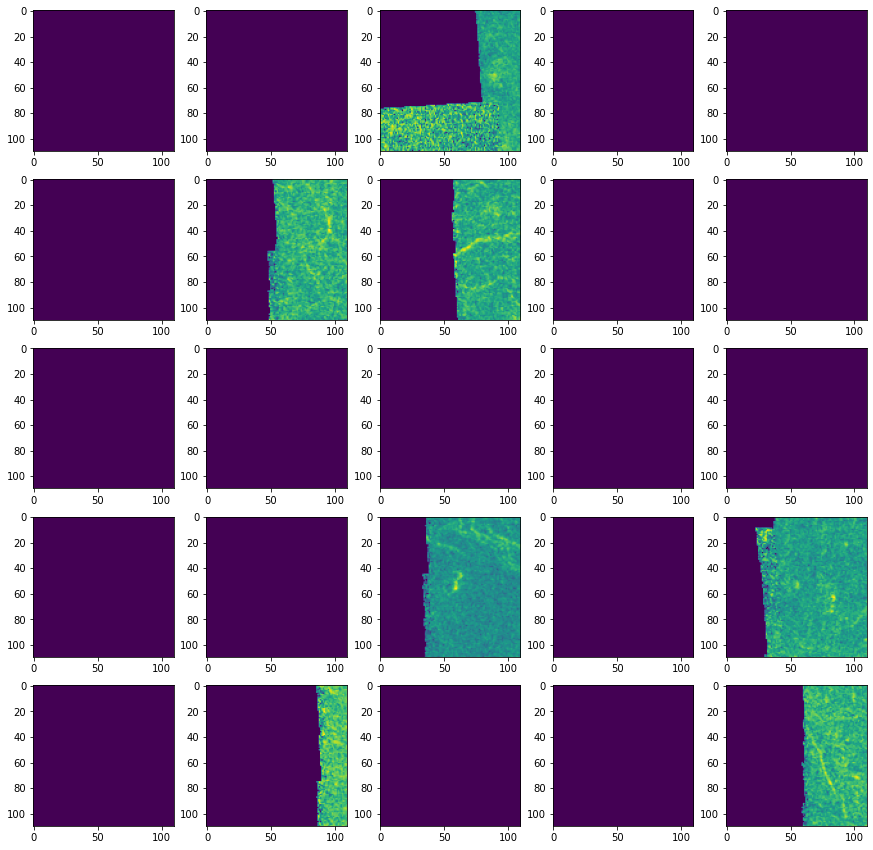

In [18]:
import random

train_сorrupted = corrupted_images_definition(X_train_copy)
random.shuffle(train_сorrupted)

f, axarr = plt.subplots(5,5,figsize=(15,15))
for i in range(5):
    for j in range(5):
        axarr[i,j].imshow(X_train_copy[train_сorrupted[i*5+j]])

Загрузим датасет снова и удалим лишнее.

In [19]:
X_train = pd.read_csv('../input/volcanoes_train/train_images.csv')
y_train = pd.read_csv('../input/volcanoes_train/train_labels.csv')
X_test = pd.read_csv('../input/volcanoes_test/test_images.csv')
y_test = pd.read_csv('../input/volcanoes_test/test_labels.csv')

# Починка
fixing_X(X_train)
fixing_X(X_test)

# Удаление испорченных 
train_сorrupted_list = corrupted_images_definition(np.resize(X_train, (X_train.shape[0], 110, 110)))
test_сorrupted_list = corrupted_images_definition(np.resize(X_test, (X_test.shape[0], 110, 110)))
delete_corrupted_images(X_train, y_train, train_сorrupted_list)
delete_corrupted_images(X_test, y_test, test_сorrupted_list)

Получились новые размеры выборок.

In [20]:
print("X_train ->",X_train.shape,"\ny_train ->",y_train.shape,"\nX_test ->",X_test.shape,"\ny_test ->",y_test.shape)

X_train -> (6791, 12100) 
y_train -> (6791, 4) 
X_test -> (2655, 12100) 
y_test -> (2655, 4)


## 3 Простейшая CNN
Первая сеть будет просто определять наличие вулкана на изображении. Это сверточная нейронная сеть (CNN - convolutional neural network).
В нашем случае будет использовать примитивная нейронная сеть с несколькими слоями. На вход подается 11664 признаков - каждый пиксель как отдельный признак, нумерующийся по порядку. И лишь один выход - "вулкан или нет", с сигмоидной функцией активации.
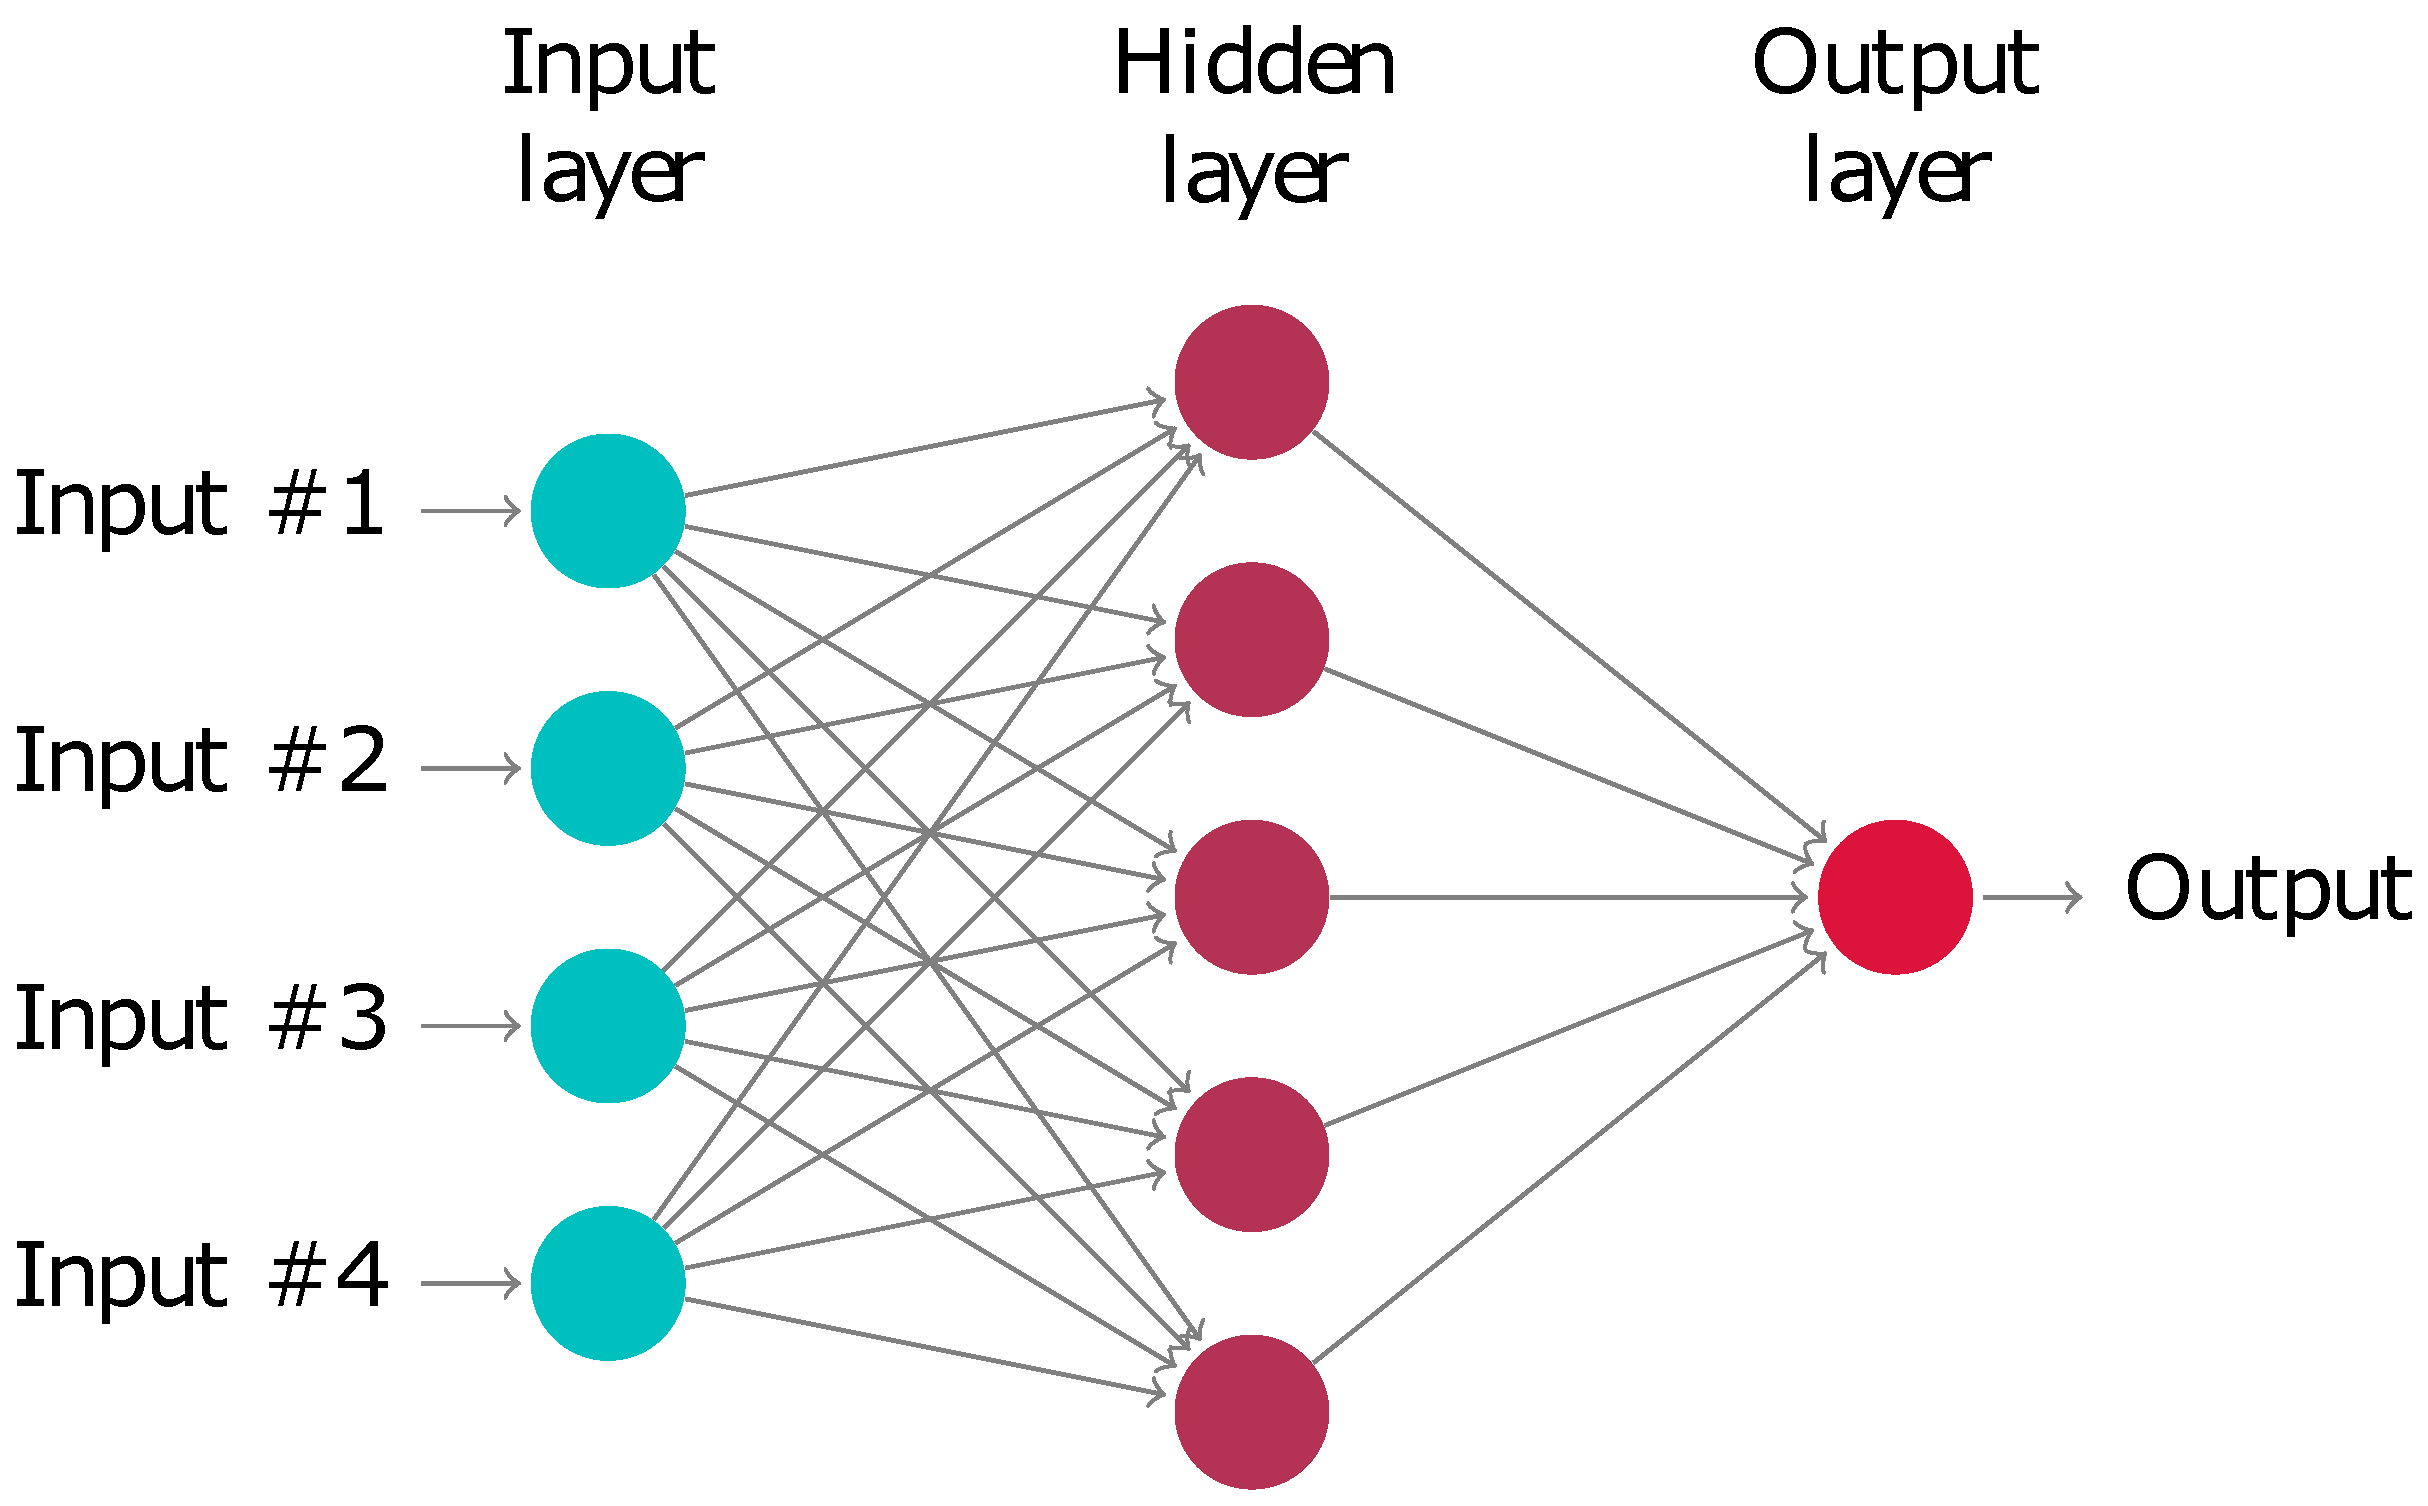
Текущая последовательная модель включает:

<ol>
  <p>Сверточный слой, с 8-ю ядрами 5 на 5</p>
  <p>Подвыборочный слой, с ядром 2 на 2</p>
  <p>Сверточный слой, с 16-ю ядрами 3 на 3</p>
  <p>Подвыборочный слой, с ядром 2 на 2</p>
  <p>Сжимающий слой для преобразования изображения из 2D в 1D набор признаков</p>
  <p>Уплотняющий слой с сигмоидной функцией активации (выходной)</p>
</ol>

### 3.1 Подготовка данных

In [21]:
# Разбиение тестовой выборки на тестовую и подтвреждающую (50% на 50%)
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=22)

print("Размеры частей датасета после дополнительного разбиения:\n\n",
      "70%   X_train ->",X_train.shape,"\n       y_train ->",y_train.shape,
      "\n\n 15%   X_test ->",X_test.shape,"\n       y_test ->",y_test.shape,
      "\n\n 15%   X_val ->",X_val.shape,"\n       y_val ->",y_val.shape)

Размеры частей датасета после дополнительного разбиения:

 70%   X_train -> (6791, 12100) 
       y_train -> (6791, 4) 

 15%   X_test -> (1327, 12100) 
       y_test -> (1327, 4) 

 15%   X_val -> (1328, 12100) 
       y_val -> (1328, 4)


In [22]:
# Изменение размеров выборок
print("До изменения размеров")
print("70%   X_train ->",X_train.shape,"\n      y_train ->",y_train.shape,"\n\n15%   X_test ->",X_test.shape,"\n      y_test ->",y_test.shape,"\n\n15%   X_val ->",X_val.shape,"\n      y_val ->",y_val.shape)

X_test = np.resize(X_test, (X_test.shape[0], 110, 110, 1))
X_train = np.resize(X_train, (X_train.shape[0], 110, 110, 1))
X_val = np.resize(X_val, (X_val.shape[0], 110, 110, 1))

print("\nПосле изменения размеров")
print("70%   X_train ->",X_train.shape,"\n      y_train ->",y_train.shape,"\n\n15%   X_test ->",X_test.shape,"\n      y_test ->",y_test.shape,"\n\n15%   X_val ->",X_val.shape,"\n      y_val ->",y_val.shape)

До изменения размеров
70%   X_train -> (6791, 12100) 
      y_train -> (6791, 4) 

15%   X_test -> (1327, 12100) 
      y_test -> (1327, 4) 

15%   X_val -> (1328, 12100) 
      y_val -> (1328, 4)

После изменения размеров
70%   X_train -> (6791, 110, 110, 1) 
      y_train -> (6791, 4) 

15%   X_test -> (1327, 110, 110, 1) 
      y_test -> (1327, 4) 

15%   X_val -> (1328, 110, 110, 1) 
      y_val -> (1328, 4)


In [23]:
from keras.utils.np_utils import to_categorical
# Исключение всех лишних критериев (Радиус, Число вулканов и тип определенности вулкана)
y_train = y_train["Volcano?"]
y_test = y_test["Volcano?"]
y_val = y_val["Volcano?"]
# Нормализация изображений от 0 до 1
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0
# Разбиваем один признак на 2 катигорийных при помощи One Hot Encoding
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)
y_val = to_categorical(y_val, num_classes = 2)

### 3.2 Расширение обучающего датасета генератором
Расширение обучающей выборки (базы изображений) будет производиться за счет всевозможных поворотов и отражений исходного датасета.
В пакете Keras существует ImageDataGenerator, который может осуществлять сдвиги, повороты и засвечивания изображений, увеличивая объем доступных данных.

In [24]:
from keras.preprocessing.image import ImageDataGenerator

dataGenerator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=90,
        zoom_range = 0.1, 
        width_shift_range=0,
        height_shift_range=0, 
        horizontal_flip=False,
        vertical_flip=False)
dataGenerator.fit(X_train)

print(X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]+X_val.shape[0])*100, "%   X_train ->", X_train.shape,
      "\n      y_train ->",y_train.shape,
      "\n\n", X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]+X_val.shape[0])*100, "%   X_test ->", X_test.shape,
      "\n      y_test ->",y_test.shape,
      "\n\n", X_val.shape[0]/(X_train.shape[0]+X_test.shape[0]+X_val.shape[0])*100, "%   X_val ->", X_val.shape,
      "\n      y_val ->",y_val.shape)

71.89286470463688 %   X_train -> (6791, 110, 110, 1) 
      y_train -> (6791, 2) 

 14.048274401863223 %   X_test -> (1327, 110, 110, 1) 
      y_test -> (1327, 2) 

 14.058860893499894 %   X_val -> (1328, 110, 110, 1) 
      y_val -> (1328, 2)


### 3.3 Создание модели

In [25]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.optimizers import Adam

simple_model = Sequential()
simple_model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', input_shape = (110,110,1)))
simple_model.add(MaxPool2D(pool_size=(2,2)))
simple_model.add(Conv2D(filters = 16, kernel_size = (3,3), activation ='relu'))
simple_model.add(MaxPool2D(pool_size=(2,2)))
simple_model.add(Flatten())
simple_model.add(Dense(y_train.shape[1], activation = "sigmoid"))

In [26]:
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 106, 106, 8)       208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 53, 53, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 51, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 2)                 2

In [27]:
# Компиляция модели с оптимизацией Adam для оптимизации функции потерь 
# и категориальной перекрестной энтропией для для вычисления функции потерь
simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### 3.4 Обучение модели
Если функция потерь валидации сильно больше ошибки обучения, значит модель переобучилась.

In [28]:
# Обучение модели батчами по 64, в 8 эпох:
simple_model_trained = simple_model.fit(X_train, y_train, batch_size=64, epochs = 8, validation_data = (X_val,y_val), steps_per_epoch=X_train.shape[0] // 64)

Epoch 1/8
106/106 [==============================] - 27s 244ms/step - loss: 0.4195 - accuracy: 0.8485 - val_loss: 0.4592 - val_accuracy: 0.8245
Epoch 2/8
106/106 [==============================] - 25s 237ms/step - loss: 0.4079 - accuracy: 0.8545 - val_loss: 0.4533 - val_accuracy: 0.8245
Epoch 3/8
106/106 [==============================] - 25s 234ms/step - loss: 0.3769 - accuracy: 0.8551 - val_loss: 0.3701 - val_accuracy: 0.8298
Epoch 4/8
106/106 [==============================] - 25s 231ms/step - loss: 0.2906 - accuracy: 0.8840 - val_loss: 0.2763 - val_accuracy: 0.9021
Epoch 5/8
106/106 [==============================] - 25s 237ms/step - loss: 0.2178 - accuracy: 0.9206 - val_loss: 0.2599 - val_accuracy: 0.8886
Epoch 6/8
106/106 [==============================] - 25s 232ms/step - loss: 0.1967 - accuracy: 0.9282 - val_loss: 0.2093 - val_accuracy: 0.9239
Epoch 7/8
106/106 [==============================] - 27s 259ms/step - loss: 0.1630 - accuracy: 0.9395 - val_loss: 0.2159 - val_accuracy:

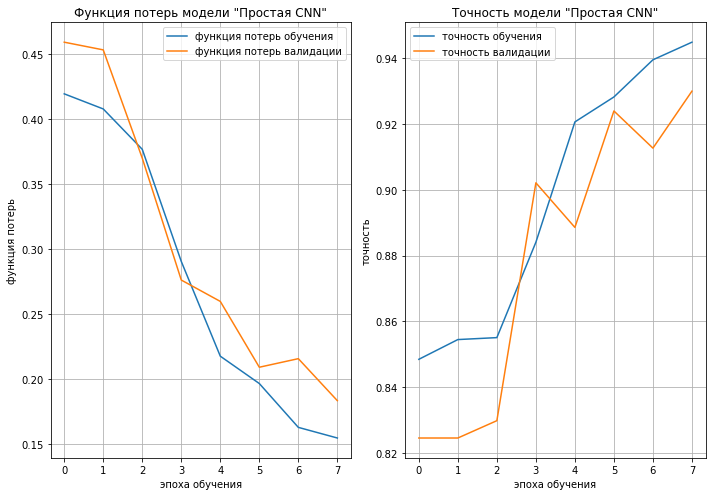

In [29]:
def drawing_training_graph(model, model_name):
    x = model.epoch
    y1 = model.history['loss']
    y2 = model.history['val_loss']
    y3 = model.history['accuracy']
    y4 = model.history['val_accuracy']
    

    fig, axs = plt.subplots(1, 2)
    axs[0].plot(x, y1, label = 'функция потерь обучения')
    axs[0].plot(x, y2, label = 'функция потерь валидации')
    axs[0].set_xlabel('эпоха обучения')
    axs[0].set_ylabel('функция потерь')
    axs[0].grid(True)
    axs[0].set_title('Функция потерь модели ' + model_name)
    axs[0].legend()

    axs[1].plot(x, y3, label = 'точность обучения')
    axs[1].plot(x, y4, label = 'точность валидации')
    axs[1].set_xlabel('эпоха обучения')
    axs[1].set_ylabel('точность')
    axs[1].grid(True)
    axs[1].set_title('Точность модели ' + model_name)
    axs[1].legend()

    fig.tight_layout()
    plt.show()
    
drawing_training_graph(simple_model_trained, '"Простая CNN"')

In [30]:
# Оценка простой модели
score_simple_model = simple_model.evaluate(X_test, y_test)
print('Функция потерь в тесте ->', score_simple_model[0])
print('Точность в тесте->', score_simple_model[1])

42/42 [==============================] - 2s 42ms/step - loss: 0.1699 - accuracy: 0.9382
Функция потерь в тесте -> 0.16990339756011963
Точность в тесте-> 0.9382064938545227


## 4 CNN c Dropout (с забыванием)
Слои с Dropout (забыванием) будут уменьшать переобучение нейронной сети. Они случайным убразом удаляют связи между узлами в слоях. Текущая модель будет иметь схожее строение с предыдущей, только после каждого подвыборочного слоя будет идти слой с забыванием. Т.е. добавилось 2 слоя с Dropout.
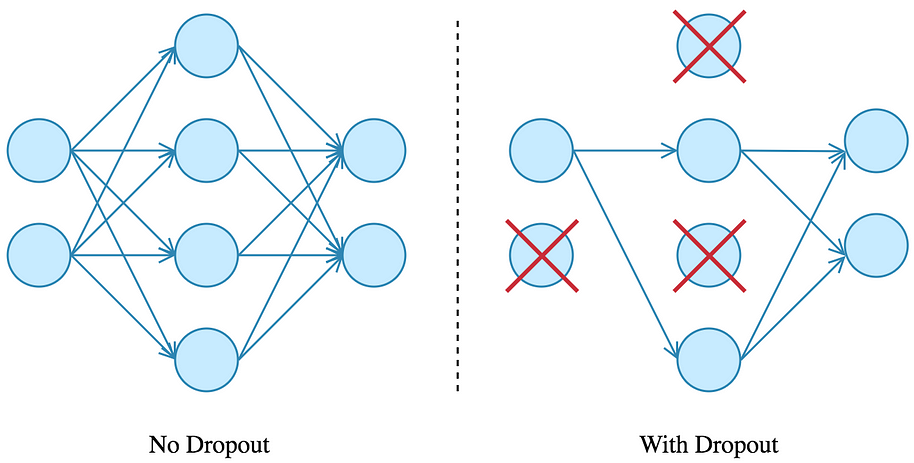

### 4.1 Создание модели

In [31]:
dropout_model = Sequential()
dropout_model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'same',activation ='relu', input_shape = (110,110,1)))
dropout_model.add(MaxPool2D(pool_size=(2,2)))
dropout_model.add(Dropout(0.5))
dropout_model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'same',activation ='relu'))
dropout_model.add(MaxPool2D(pool_size=(2,2)))
dropout_model.add(Dropout(0.5))
dropout_model.add(Flatten())
dropout_model.add(Dense(y_train.shape[1], activation = "sigmoid"))

In [32]:
dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 110, 110, 8)       208       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 55, 55, 8)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 55, 55, 8)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 55, 16)        1168      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 27, 27, 16)       

### 4.2 Обучение модели

In [33]:
# Обучение модели на 16 эпохах
dropout_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dropout_model_trained = dropout_model.fit(X_train, y_train, batch_size=64, epochs = 16, validation_data = (X_val,y_val), steps_per_epoch=X_train.shape[0] // 64)

Epoch 1/16
106/106 [==============================] - 33s 295ms/step - loss: 0.4453 - accuracy: 0.8499 - val_loss: 0.6235 - val_accuracy: 0.8245
Epoch 2/16
106/106 [==============================] - 31s 293ms/step - loss: 0.4144 - accuracy: 0.8543 - val_loss: 0.5684 - val_accuracy: 0.8245
Epoch 3/16
106/106 [==============================] - 30s 282ms/step - loss: 0.4075 - accuracy: 0.8557 - val_loss: 0.5821 - val_accuracy: 0.8245
Epoch 4/16
106/106 [==============================] - 32s 305ms/step - loss: 0.4029 - accuracy: 0.8527 - val_loss: 0.5477 - val_accuracy: 0.8245
Epoch 5/16
106/106 [==============================] - 31s 290ms/step - loss: 0.3882 - accuracy: 0.8560 - val_loss: 0.5194 - val_accuracy: 0.8253
Epoch 6/16
106/106 [==============================] - 31s 289ms/step - loss: 0.3603 - accuracy: 0.8634 - val_loss: 0.3766 - val_accuracy: 0.8539
Epoch 7/16
106/106 [==============================] - 31s 289ms/step - loss: 0.3130 - accuracy: 0.8793 - val_loss: 0.3060 - val_ac

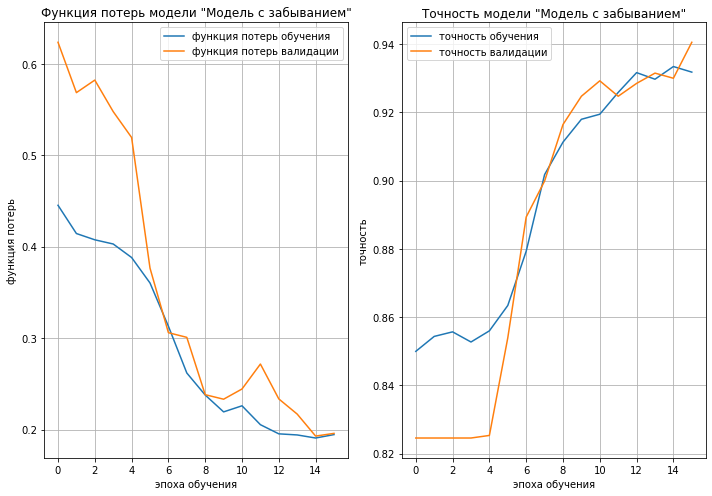

In [34]:
drawing_training_graph(dropout_model_trained, '"Модель с забыванием"')

In [35]:
score_dropout_model = dropout_model.evaluate(X_test, y_test)
print('Функция потерь в тесте ->', score_dropout_model[0])
print('Точность в тесте->', score_dropout_model[1])

42/42 [==============================] - 2s 40ms/step - loss: 0.1870 - accuracy: 0.9435
Функция потерь в тесте -> 0.18696218729019165
Точность в тесте-> 0.9434815645217896


Что лучше, чем у предыдущей модели. Также функция потерь обучения и функция потерь валидации очень близки, что показывает избавление от переобучения. Осталось только повысить точность.

## 5 CNN с большим числом слоев
В новой модели поменяются некоторые параметры и добавятся новые слои, так, что новая модель будет иметь состав:
<ol>
  <p>Сверточный слой с 2-мя ядрами 3 на 3</p>
  <p>Сверточный слой с 3-мя ядрами 3 на 3</p>
  <p>Сверточный слой с 8-ю ядрами 5 на 5</p>
  <p>Подвыборочный слой, с ядром 2 на 2</p>
  <p>Сверточный слой с 16-ю ядрами 5 на 5</p>
  <p>Слой с забыванием, с коэффициентом забывания 0.5</p>
  <p>Подвыборочный слой, с ядром 2 на 2</p>
  <p>Сверточный слой с 24-мя ядрами 7 на 7</p>
  <p>Слой с забыванием, с коэффициентом забывания 0.5</p>
  <p>Сжимающий слой для преобразования изображения из 2D в 1D набор признаков</p>
  <p>Уплотняющий слой с сигмоидной функцией активации (выходной)</p>
</ol>


### 5.2 Создание новой модели

In [39]:
large_model = Sequential()
large_model.add(Conv2D(filters = 2, kernel_size = (3,3),padding = 'same',activation ='relu', input_shape = (110,110,1)))
large_model.add(Conv2D(filters = 4, kernel_size = (3,3),padding = 'same',activation ='relu'))
large_model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'same',activation ='relu'))
large_model.add(MaxPool2D(pool_size=(2,2)))
large_model.add(Dropout(0.5))
large_model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'same',activation ='relu'))
large_model.add(MaxPool2D(pool_size=(2,2)))
large_model.add(Conv2D(filters = 24, kernel_size = (7,7),padding = 'same',activation ='relu'))
large_model.add(Dropout(0.5))
large_model.add(Flatten())
large_model.add(Dense(y_train.shape[1], activation = "sigmoid"))

In [40]:
large_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 110, 110, 2)       20        
                                                                 
 conv2d_10 (Conv2D)          (None, 110, 110, 4)       76        
                                                                 
 conv2d_11 (Conv2D)          (None, 110, 110, 8)       808       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 55, 55, 8)        0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 55, 55, 8)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 55, 55, 16)        3216      
                                                      

### 5.3 Обучение модели

In [41]:
# Обучение модели будет осуществляться 32 эпох, батчами 64
large_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
large_model_trained = large_model.fit(dataGenerator.flow(X_train, y_train, batch_size=64), epochs=16, validation_data=[X_val, y_val], steps_per_epoch=X_train.shape[0] // 64)

Epoch 1/16
106/106 [==============================] - 121s 1s/step - loss: 0.4363 - accuracy: 0.8481 - val_loss: 0.4982 - val_accuracy: 0.8245
Epoch 2/16
106/106 [==============================] - 103s 972ms/step - loss: 0.4169 - accuracy: 0.8543 - val_loss: 0.4692 - val_accuracy: 0.8245
Epoch 3/16
106/106 [==============================] - 110s 1s/step - loss: 0.4122 - accuracy: 0.8539 - val_loss: 0.4476 - val_accuracy: 0.8245
Epoch 4/16
106/106 [==============================] - 98s 928ms/step - loss: 0.3112 - accuracy: 0.8897 - val_loss: 0.2413 - val_accuracy: 0.9134
Epoch 5/16
106/106 [==============================] - 97s 919ms/step - loss: 0.2149 - accuracy: 0.9266 - val_loss: 0.2254 - val_accuracy: 0.9255
Epoch 6/16
106/106 [==============================] - 98s 920ms/step - loss: 0.1935 - accuracy: 0.9364 - val_loss: 0.2121 - val_accuracy: 0.9217
Epoch 7/16
106/106 [==============================] - 97s 913ms/step - loss: 0.1770 - accuracy: 0.9385 - val_loss: 0.1608 - val_accur

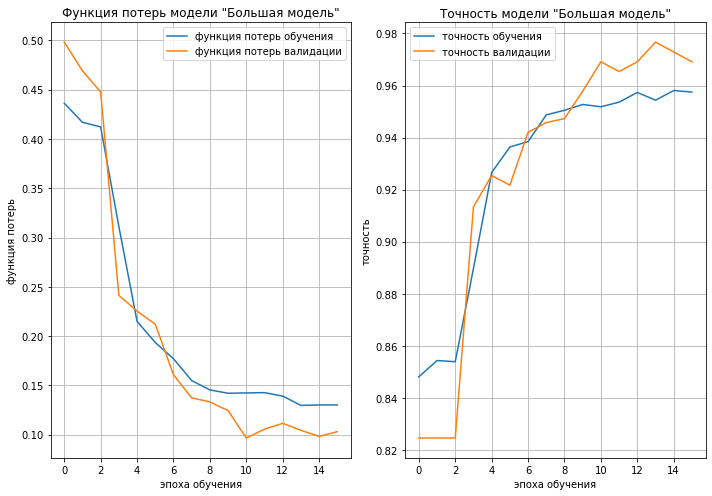

In [42]:
drawing_training_graph(large_model_trained, '"Большая модель"')

In [43]:
score_large_model = large_model.evaluate(X_test, y_test)
print('Функция потерь в тесте ->', score_large_model[0])
print('Точность в тесте->', score_large_model[1])

42/42 [==============================] - 4s 103ms/step - loss: 0.1230 - accuracy: 0.9616
Функция потерь в тесте -> 0.12298686057329178
Точность в тесте-> 0.9615674614906311


## 6 Выводы
В заключение можно сказать, что точность работы моделей улучшилась и достаточно сильно превзошла 0.9 в последней модели.
Добавление забывания увеличивает необходимое число эпох обучения, при их наличии нужно больше эпох для достижения прежних результатов, хотя это убирает проблему переобучения. Большое число нейронов в слоях сильно замедляет процесс улучшения качества, а иногда и заставляет модель застрять на одном уровне.
Однако Сверточная нейронная сеть, ожидаемо, хорошо справилась с поставленной задачей. Постепенное усложнение помогло создать модель, работающую с высокой точностью и отвечающую эффективности CNN при работе с изображениями, что демонстрирует график ниже.

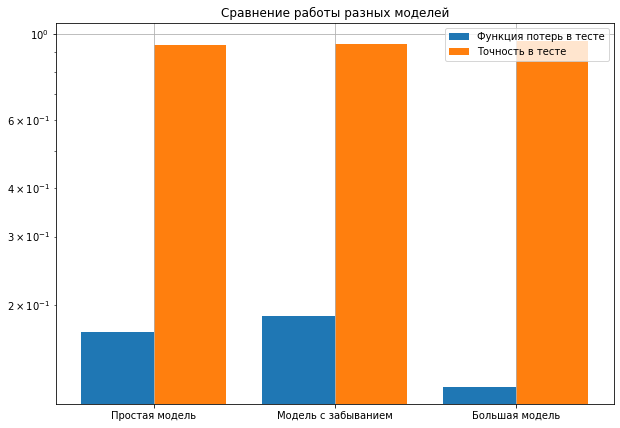

In [45]:
y1 = [score_simple_model[0], score_dropout_model[0], score_large_model[0]]
y2 = [score_simple_model[1], score_dropout_model[1], score_large_model[1]]
col = ['Простая модель', 'Модель с забыванием', 'Большая модель']

x_axis = np.arange(len(col))

plt.rcParams["figure.figsize"] = (10,7)
plt.bar(x_axis -0.2, y1, width=0.4, label = 'Функция потерь в тесте')
plt.bar(x_axis +0.2, y2, width=0.4, label = 'Точность в тесте')

plt.yscale('log')
plt.title('Сравнение работы разных моделей')
plt.xticks(x_axis, col)
plt.grid()
plt.legend()
plt.show()